# Interacting with CLIP

In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.1.1+cu121


## Loading the model

In [2]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline

colors = ['red', 'green', 'blue', 'yellow', 'purple']
cars = [f'a {color} car' for color in colors]

descriptions = cars + [
    "a man drinking a coffee in a restaurante",
    "a astronaut riding a horse"
]

descriptions

['a red car',
 'a green car',
 'a blue car',
 'a yellow car',
 'a purple car',
 'a man drinking a coffee in a restaurante',
 'a astronaut riding a horse']

In [5]:
text_tokens = clip.tokenize([x for x in descriptions]).cuda()
text_tokens[0].shape

torch.Size([77])

In [6]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

In [7]:
text_features[0].shape
text_features.shape

torch.Size([7, 512])

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [8]:
normalized = text_features
normalized /= normalized.norm(dim=-1, keepdim=True)
similarity = normalized.cpu().numpy() @ normalized.cpu().numpy().T

In [9]:
from pandas import DataFrame as DF
DF(similarity)

,0,1,2,3,4,5,6
0,1.000977,0.819824,0.807617,0.808105,0.785156,0.575684,0.587402
1,0.819824,1.000000,0.828613,0.815918,0.773926,0.601074,0.584473
2,0.807617,0.828613,1.000000,0.784668,0.807617,0.567871,0.591797
3,0.808105,0.815918,0.784668,1.000000,0.746094,0.554199,0.549805
4,0.785156,0.773926,0.807617,0.746094,1.000000,0.532227,0.542969
5,0.575684,0.601074,0.567871,0.554199,0.532227,0.999023,0.536621
6,0.587402,0.584473,0.591797,0.549805,0.542969,0.536621,1.000000


<Axes: >

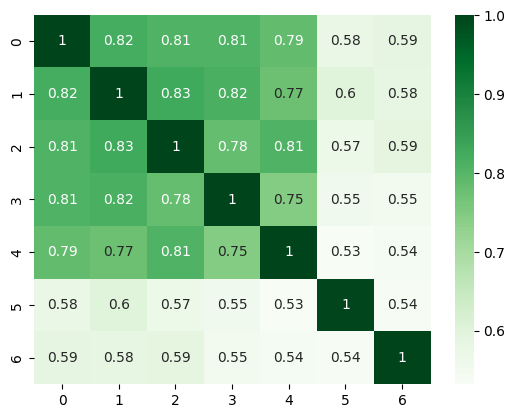

In [10]:
import seaborn as sns
sns.heatmap(similarity,annot=True, cmap="Greens")

## UMAP
Reduce dimensions and plot

Sart with scaling the data [doku](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [12]:
import umap
import sklearn as sk

data = text_features.cpu()

reducer = umap.UMAP(n_neighbors=3)
scaled = sk.preprocessing.StandardScaler().fit_transform(data)

In [13]:
reduced_umap = reducer.fit_transform(data)
reduced_umap.shape

(7, 2)

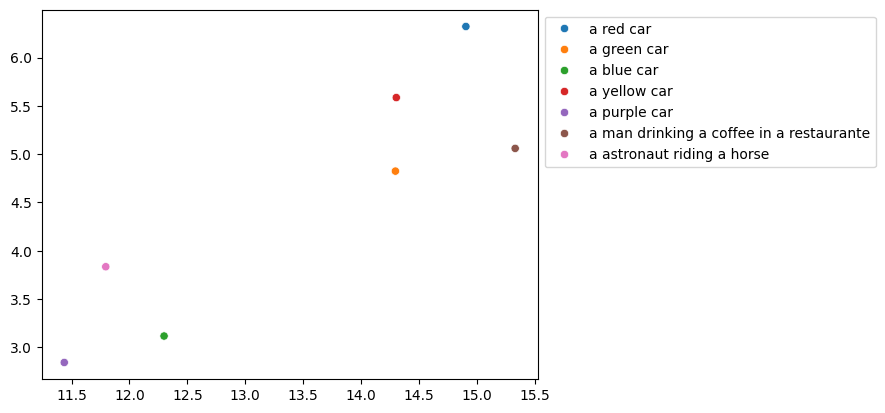

In [14]:
p = sns.scatterplot(x=reduced_umap[:,0], y=reduced_umap[:,1], hue=descriptions)
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

## PCA

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)
pca.explained_variance_ratio_

array([0.34552009, 0.23931587])

In [16]:
reduced_pca=pca.transform(data)
reduced_pca

array([[-0.18167585,  0.00626924],
       [-0.16453239, -0.04056074],
       [-0.18890161,  0.02944947],
       [-0.21182645, -0.02887478],
       [-0.23010665,  0.01485306],
       [ 0.5008982 , -0.47072496],
       [ 0.47614476,  0.48958871]])

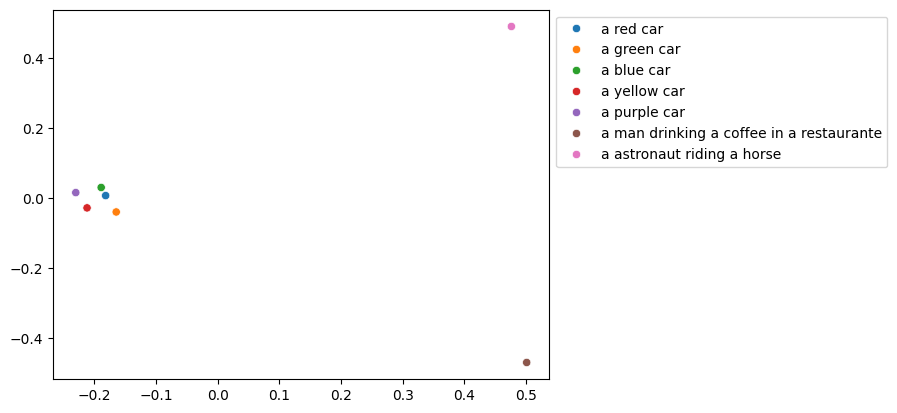

In [17]:
p = sns.scatterplot(x=reduced_pca[:,0], y=reduced_pca[:,1], hue=descriptions)
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))